In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A
from efficientnet_pytorch import EfficientNet

# Data load

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="2"

In [3]:
train_total = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train_total.head()

,uid,img_path,disease,disease_code
0,10000,train_imgs/10000.jpg,시설포도노균병,1
1,10001,train_imgs/10001.jpg,시설포도노균병,1
2,10002,train_imgs/10002.jpg,시설포도노균병반응,2
3,10003,train_imgs/10003.jpg,축과병,4
4,10004,train_imgs/10004.jpg,시설포도노균병,1


In [5]:
train_total['disease'].unique()

array(['시설포도노균병', '시설포도노균병반응', '축과병', '정상', '시설포도탄저병', '일소피해',
       '시설포도탄저병반응'], dtype=object)

In [6]:
test.head()

,uid,img_path
0,20000,test_imgs/20000.jpg
1,20001,test_imgs/20001.jpg
2,20002,test_imgs/20002.jpg
3,20003,test_imgs/20003.jpg
4,20004,test_imgs/20004.jpg


In [7]:
device = torch.device("cuda:0")
batch_size = 64
dropout_rate = 0.1
class_n = len(train_total['disease_code'].unique())
learning_rate = 1e-4
epochs = 30
save_path = 'models/model.pt'

# augmentation

In [8]:
albumentations_transform = A.Compose([
    A.RandomGamma(),
    A.ShiftScaleRotate(),
    A.GaussianBlur(),
    A.GaussNoise()
])

In [9]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None,transformer=None, mode='train'):
        self.mode = mode
        self.files = files
        self.transformer = transformer
        if mode == 'train':
            self.labels = labels
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        if self.mode == 'train':
            img = cv2.imread('data/train_imgs/'+self.files[i])
            img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            if self.transformer != None:
                img = self.transformer(image=img)
                img = np.transpose(img["image"], (2,0,1))
            else:
                img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'label' : torch.tensor(self.labels[i], dtype=torch.long)
            }
        else:
            img = cv2.imread('data/test_imgs/'+self.files[i])
            img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
            }

In [10]:
train = train_total.iloc[:200]
val = train_total.iloc[200:]

In [11]:
train_dataset = CustomDataset(train['img_path'].str.split('/').str[-1].values, train['disease_code'].values, transformer=albumentations_transform)
val_dataset = CustomDataset(val['img_path'].str.split('/').str[-1].values, val['disease_code'].values, transformer=albumentations_transform)
test_dataset = CustomDataset(test['img_path'].str.split('/').str[-1], labels=None, mode='test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

# 모델 

In [12]:
# class CNN_Model(nn.Module):
#     def __init__(self, class_n, rate=0.1):
#         super(CNN_Model, self).__init__()
#         # self.model = models.resnet50(pretrained=True)
#         self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=class_n)
#         self.dropout = nn.Dropout(rate)
#         self.output_layer = nn.Linear(in_features=1000, out_features=class_n, bias=True)
    
#     def forward(self, inputs):
#         output = self.output_layer(self.dropout(self.model(inputs)))
#         return output

In [13]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=class_n, advprop=True)
model._dropout.p = dropout_rate

model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

In [15]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
            
        return loss

In [16]:
loss_plot, val_loss_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    scheduler.step(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)
        print(f"## _{epoch+1}_Model Save")

4it [00:16,  4.06s/it, Epoch=1, Loss=1.819390, Total Loss=1.913325]
1it [00:04,  4.31s/it, Epoch=1, Val Loss=1.998623, Total Val Loss=1.998623]


## _1_Model Save


4it [00:16,  4.00s/it, Epoch=2, Loss=1.754654, Total Loss=1.803007]
1it [00:04,  4.22s/it, Epoch=2, Val Loss=1.938870, Total Val Loss=1.938870]


## _2_Model Save


4it [00:15,  3.98s/it, Epoch=3, Loss=1.681445, Total Loss=1.708199]
1it [00:04,  4.18s/it, Epoch=3, Val Loss=1.909039, Total Val Loss=1.909039]


## _3_Model Save


4it [00:15,  4.00s/it, Epoch=4, Loss=1.764968, Total Loss=1.675858]
1it [00:04,  4.20s/it, Epoch=4, Val Loss=1.876250, Total Val Loss=1.876250]


## _4_Model Save


4it [00:16,  4.01s/it, Epoch=5, Loss=1.497542, Total Loss=1.590721]
1it [00:04,  4.24s/it, Epoch=5, Val Loss=1.860877, Total Val Loss=1.860877]


## _5_Model Save


4it [00:15,  4.00s/it, Epoch=6, Loss=1.553161, Total Loss=1.540721]
1it [00:04,  4.23s/it, Epoch=6, Val Loss=1.892240, Total Val Loss=1.892240]
4it [00:15,  4.00s/it, Epoch=7, Loss=1.422281, Total Loss=1.468081]
1it [00:04,  4.18s/it, Epoch=7, Val Loss=1.814093, Total Val Loss=1.814093]


## _7_Model Save


4it [00:16,  4.04s/it, Epoch=8, Loss=1.294406, Total Loss=1.458148]
1it [00:04,  4.26s/it, Epoch=8, Val Loss=1.827888, Total Val Loss=1.827888]
4it [00:16,  4.02s/it, Epoch=9, Loss=2.206275, Total Loss=1.606097]
1it [00:04,  4.29s/it, Epoch=9, Val Loss=1.886413, Total Val Loss=1.886413]
4it [00:16,  4.01s/it, Epoch=10, Loss=1.606884, Total Loss=1.451368]
1it [00:04,  4.25s/it, Epoch=10, Val Loss=1.847851, Total Val Loss=1.847851]
4it [00:15,  4.00s/it, Epoch=11, Loss=1.234188, Total Loss=1.338648]
1it [00:04,  4.24s/it, Epoch=11, Val Loss=1.799368, Total Val Loss=1.799368]


## _11_Model Save


4it [00:16,  4.01s/it, Epoch=12, Loss=1.272523, Total Loss=1.287301]
1it [00:04,  4.24s/it, Epoch=12, Val Loss=1.735001, Total Val Loss=1.735001]


## _12_Model Save


4it [00:16,  4.01s/it, Epoch=13, Loss=1.431953, Total Loss=1.350198]
1it [00:04,  4.23s/it, Epoch=13, Val Loss=1.789295, Total Val Loss=1.789295]
4it [00:15,  3.97s/it, Epoch=14, Loss=1.127660, Total Loss=1.194649]
1it [00:04,  4.21s/it, Epoch=14, Val Loss=1.712397, Total Val Loss=1.712397]


## _14_Model Save


4it [00:16,  4.00s/it, Epoch=15, Loss=1.394680, Total Loss=1.235722]
1it [00:04,  4.23s/it, Epoch=15, Val Loss=1.741857, Total Val Loss=1.741857]
4it [00:16,  4.01s/it, Epoch=16, Loss=1.700818, Total Loss=1.318475]
1it [00:04,  4.22s/it, Epoch=16, Val Loss=1.716136, Total Val Loss=1.716136]
4it [00:15,  3.97s/it, Epoch=17, Loss=1.067710, Total Loss=1.112570]
1it [00:04,  4.24s/it, Epoch=17, Val Loss=1.580992, Total Val Loss=1.580992]


## _17_Model Save


4it [00:15,  4.00s/it, Epoch=18, Loss=1.488045, Total Loss=1.243181]
1it [00:04,  4.20s/it, Epoch=18, Val Loss=1.559289, Total Val Loss=1.559289]


## _18_Model Save


4it [00:16,  4.02s/it, Epoch=19, Loss=1.620720, Total Loss=1.262407]
1it [00:04,  4.18s/it, Epoch=19, Val Loss=1.515298, Total Val Loss=1.515298]


## _19_Model Save


4it [00:16,  4.01s/it, Epoch=20, Loss=1.237368, Total Loss=1.189342]
1it [00:04,  4.23s/it, Epoch=20, Val Loss=1.612192, Total Val Loss=1.612192]
4it [00:16,  4.02s/it, Epoch=21, Loss=1.009193, Total Loss=1.100658]
1it [00:04,  4.24s/it, Epoch=21, Val Loss=1.536739, Total Val Loss=1.536739]
4it [00:16,  4.03s/it, Epoch=22, Loss=1.252800, Total Loss=1.165082]
1it [00:04,  4.20s/it, Epoch=22, Val Loss=1.414663, Total Val Loss=1.414663]


## _22_Model Save


4it [00:16,  4.01s/it, Epoch=23, Loss=0.962756, Total Loss=1.136198]
1it [00:04,  4.19s/it, Epoch=23, Val Loss=1.401386, Total Val Loss=1.401386]


## _23_Model Save


4it [00:16,  4.01s/it, Epoch=24, Loss=1.287506, Total Loss=1.122543]
1it [00:04,  4.22s/it, Epoch=24, Val Loss=1.486587, Total Val Loss=1.486587]
4it [00:16,  4.01s/it, Epoch=25, Loss=1.177876, Total Loss=1.114658]
1it [00:04,  4.21s/it, Epoch=25, Val Loss=1.447810, Total Val Loss=1.447810]
4it [00:16,  4.02s/it, Epoch=26, Loss=0.918388, Total Loss=1.111096]
1it [00:04,  4.23s/it, Epoch=26, Val Loss=1.415572, Total Val Loss=1.415572]
4it [00:15,  3.96s/it, Epoch=27, Loss=1.189474, Total Loss=0.988702]
1it [00:04,  4.27s/it, Epoch=27, Val Loss=1.488972, Total Val Loss=1.488972]
4it [00:16,  4.00s/it, Epoch=28, Loss=0.919914, Total Loss=0.974323]
1it [00:04,  4.23s/it, Epoch=28, Val Loss=1.365564, Total Val Loss=1.365564]


## _28_Model Save


4it [00:16,  4.01s/it, Epoch=29, Loss=1.642085, Total Loss=1.131258]
1it [00:04,  4.28s/it, Epoch=29, Val Loss=1.396263, Total Val Loss=1.396263]
4it [00:16,  4.01s/it, Epoch=30, Loss=1.185756, Total Loss=1.000651]
1it [00:04,  4.21s/it, Epoch=30, Val Loss=1.207162, Total Val Loss=1.207162]

## _30_Model Save


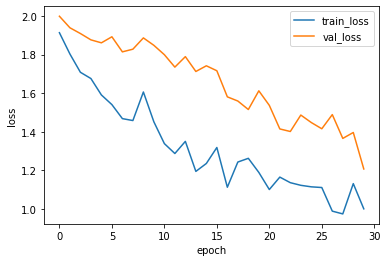

In [17]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [18]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    training = False
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        with torch.no_grad():
            output = model(img)
        output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

In [19]:
preds = predict(test_dataloader)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
75it [05:30,  4.41s/it]


In [20]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1] = preds

In [21]:
submission.to_csv('cls_baseline.csv', index=False)